# Machine learning ISUP - M2 : LDA - Logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Hand-made discriminant analysis

In [2]:
np.random.seed(0)

In [3]:
def covariance(sigma1=1., sigma2=1., theta=0.):
    """
        Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
    """
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    cov = np.array([[sigma1, 0.],
                   [0, sigma2]])
    return rotation.dot(cov.dot(rotation.T))

Write a function that generates a multivariate Gaussian sample of mean $\mu$, covariance defined by $(\sigma_1, \sigma_2, \theta)$ and size $n$.
The corresponding numpy array should be of size $(n, 2)$.

Compute the mean and the empirical covariance of the sample using Numpy routines.

Here we generate the adequate sample using the eigen values method. We also found that Cholesky is widely used.

In [4]:
from scipy import linalg
from scipy.stats import norm
def Gaussian_sample(mu,sigma1,sigma2,theta,n):
    """
        Return a multivariate Gaussian sample X of size (n,2), with particular parameters. 
    """
    # Building the covariance matrix corresponding to the paramters, using the previous function "covariance"
    sigma = covariance( sigma1, sigma2, theta)
    
    # Extracting the eigen values/vector :
    # Even if we already know them, we figured we should use the already imported library "linalg"
    eigen_val_vec = np.linalg.eig(sigma)
    
    mat_eigen_values = np.diagflat(eigen_val_vec[0]) # Diagonal matrix of eigen values
    mat_eigen_vectors = eigen_val_vec[1] # Matrix of eigen vector
    
    # Generating a 2-dimensional gaussian sample of size n, centered in (0,0) and with sigma = [[1,0],[0,1]]
    X = np.random.normal( size = (2,n) )
    
    # Transforming the data according to the wanted mean and covariance matrix
    for i in range(50):
        X[:,i] = np.sqrt(mat_eigen_values) @ mat_eigen_vectors @ X[:,i]  + mu
    
    return(X.T)   

Generate two multivariate Gaussian samples of size $n_1 = n_2 = 50$ with different means and equal covariance matrices.
Plot both samples with different markers.

In [5]:
np.random.seed(0)

n1=50
n2=50
mu1=[1,1]
mu2=[-1,-1]
sigma=1
X1=Gaussian_sample(mu1,sigma,sigma,0,n1)
X2=Gaussian_sample(mu2,sigma,sigma,0,n2)


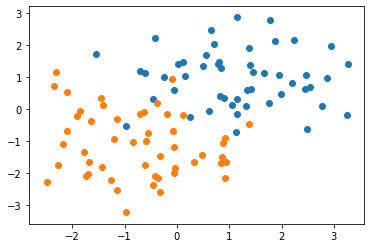

In [6]:
# Plotting the Gaussian samples :
plt.scatter(X1.T[0], X1.T[1])
plt.scatter(X2.T[0], X2.T[1])



In [7]:
# Plotting function 

def plotXY(X, Y):
    if X.shape == Y.shape:
        X1 = X
        X2 = Y
    else:
        X1 = X[Y == Y.max()]
        X2 = X[Y == Y.min()]
    plt.plot(X1[:, 0], X1[:, 1], ">", label="Class 1",color='lightseagreen')
    plt.plot(X2[:, 0], X2[:, 1], "d", label="Class 2",color='peachpuff')
    plt.axis('equal')

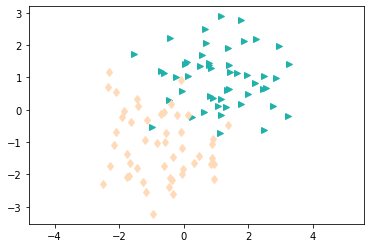

In [8]:
# Alternative plotting of the two samples :
plotXY(X1, X2)



Based on the following code, implement a linear discriminant classifier, taking as parameters an $n \times 2$ Numpy array as data and a size-$n$ array of labels.

In [9]:
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin

class LDA(BaseEstimator, LinearClassifierMixin):
    """
        LDA classifier for two classes.
    """
    def __init__(self, prior=None):
        """
            prior: wether to use prior in the intercept. Default is false.
        """
        self.prior = prior
        
    def fit(self, X, y):
        ymax=np.max(y)
        ymin=np.min(y)
        cov=np.cov(X.T)
        invcov=np.linalg.inv(cov)
        mu1=np.mean(X[y==ymax,:],axis=0)
        mu2=np.mean(X[y==ymin,:],axis=0)
        if not self.prior:
            pi1, pi2 = 0.5, 0.5
        else:
            pi1, pi2 = np.mean(y == y.max()), np.mean(y == y.min())
        self.coef_ = (mu1 - mu2).T @ invcov
        self.intercept_ = 0.5 * (mu2.T @ invcov @ mu2 - mu1.T @ invcov @ mu1) + np.log( pi1 / pi2 )
        return(self)

    def decision_function(self, X):
        return(X.dot(self.coef_) + self.intercept_)

    def predict(self, X):
        return((self.decision_function(X) > 0)*2 - 1)

Create the Numpy arrays $X$ and $y$ based on the samples generated previously and fit a linear discriminant classifier.
Plot the data along with the classifier frontiere. 

In [10]:
def plot_frontiere(clf, data=None, num=50, label=None):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)  #Concatenation along the second axis.
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.001)
    plt.plot(x[ind], y[ind], label=label,color="crimson")

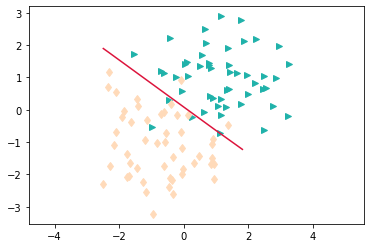

In [11]:
X = np.concatenate( (X1,X2), axis = 0 ) # Concatenation of the two samples (by binding rows)
y = np.repeat([1,2],50) # The corresponding vector of labels

lda_maison = LDA() # Creates an instance of our class LDA
lda_maison.fit(X,y) # Generates the model based on our labeled sample
lda_maison.predict(X) # Generates predictions of labels

# Plot
plotXY(X1, X2)
plot_frontiere(lda_maison, data=X, num=100, label=y)

# Visually, the LDA seems adapted. We can see that the model got the wrong label on 6 observations out of 100.

### Comparison with scikit-learn LDA

Compare the result of [scikit-learn LDA](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) (decision function and frontiere).

<bound method BaseEstimator.get_params of LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)>

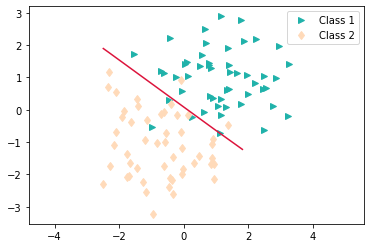

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis()
lda.fit(X,y)

plotXY(X1,X2)
plot_frontiere(lda,data=X,num=100)
plt.legend(loc="best");

# Same model, same results. Pretty comforting.

lda.get_params

## Logistic regression 


We propose now to implement the logistic regression.
Since in the TD, we already compute the gradient and the Hessian of the log-likelihood, one can implement the Newton method to solve
$$ \min_\omega \ell_{n}(\omega) := -\sum_{i=1}^n\left[Y_{i}\langle X_{i},\omega \rangle-\log(1+\exp(\langle X_{i},\omega\rangle))\right]$$

For the logistic regression, to be in accordance with the exercise we take labels in $\{0,1\}$

In [13]:
# Concatenation of X1, X2, change of labels to 0/1 :
X = np.r_[X1, X2]
y = np.r_[np.ones(X1.shape[0]), np.zeros(X2.shape[0])]

Ci-dessous, on implémente une descente selon la méthode de Newton.

Une méthode de descente est un algorithme qui passe d'une position $x_{k}$ à une position $x_{k+1}$ de la manière suivante :

$$
\left\{
    \begin{array}{ll}
        \\x_{k+1} = x_{k} + s_{k}d_{k}
        \\ \forall k \geq 0,  f(x_{k+1}) \leq f(x_{k})
    \end{array}
\right.
$$


$s_{k}$ est appelé le pas / learning rate. $d_{k}$ est appelé la direction de descente.

$\nabla$

Méthode de Newton : $d_{k} = - H_{f}(x_{k})^{-1}  \nabla f(x_{k})$

Step :  0.1  / Number of iterations :  46  / Minimum found :  [2.06423853 3.04427315]  / Loss(w) :  15.00181743128243 

Décroissance de la fonction de coût en fonction du nombre d'itérations


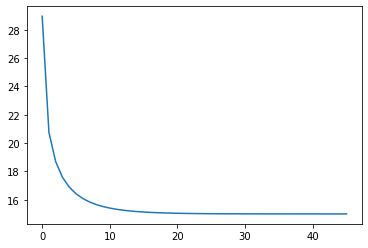


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


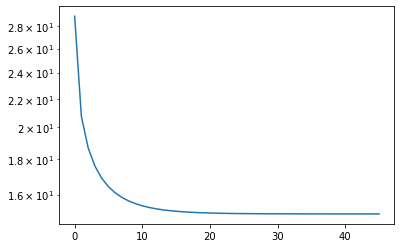



Step :  0.01  / Number of iterations :  249  / Minimum found :  [2.14415174 3.01231651]  / Loss(w) :  15.026595351298338 

Décroissance de la fonction de coût en fonction du nombre d'itérations


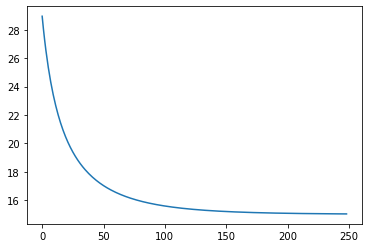


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


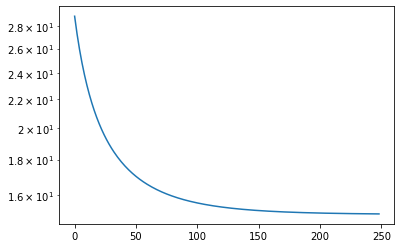



Step :  0.001  / Number of iterations :  834  / Minimum found :  [2.7095937  3.00462861]  / Loss(w) :  15.886599025499432 

Décroissance de la fonction de coût en fonction du nombre d'itérations


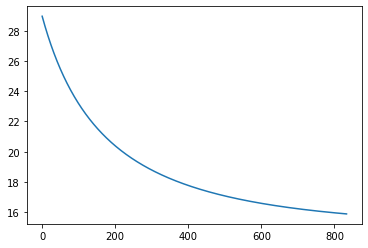


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


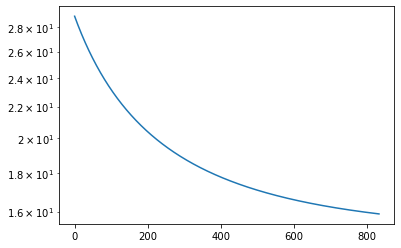



Step :  0.0001  / Number of iterations :  1404  / Minimum found :  [4.75381519 3.91760095]  / Loss(w) :  21.851946553566332 

Décroissance de la fonction de coût en fonction du nombre d'itérations


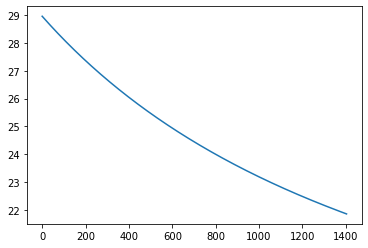


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


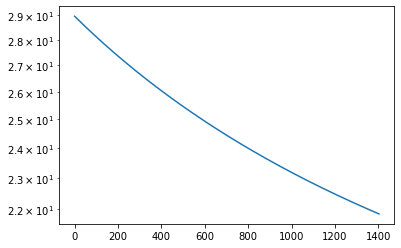



Step :  1e-05  / Number of iterations :  2  / Minimum found :  [6.77931422 5.12943921]  / Loss(w) :  28.95846055751869 

Décroissance de la fonction de coût en fonction du nombre d'itérations


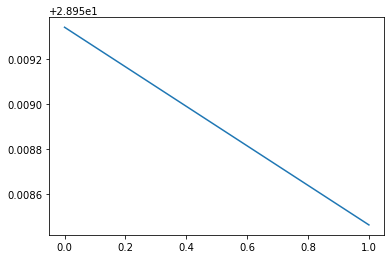


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


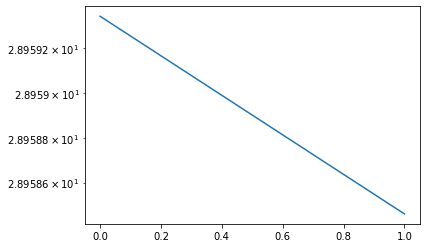



Step :  1e-06  / Number of iterations :  2  / Minimum found :  [6.77953136 5.12957314]  / Loss(w) :  28.959255279156846 

Décroissance de la fonction de coût en fonction du nombre d'itérations


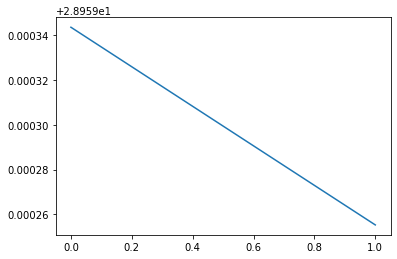


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


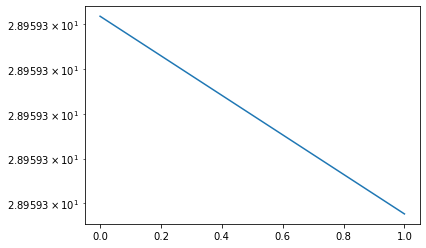



Step :  1e-07  / Number of iterations :  2  / Minimum found :  [6.77955307 5.12958653]  / Loss(w) :  28.95933475171409 

Décroissance de la fonction de coût en fonction du nombre d'itérations


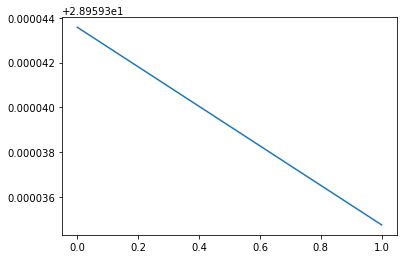


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


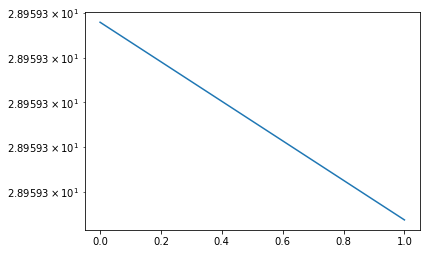



Step :  1e-08  / Number of iterations :  2  / Minimum found :  [6.77955524 5.12958787]  / Loss(w) :  28.959342698973735 

Décroissance de la fonction de coût en fonction du nombre d'itérations


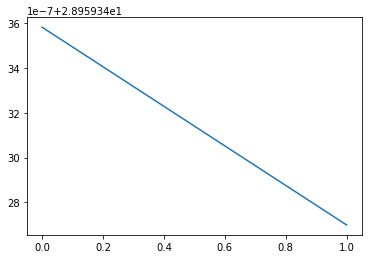


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


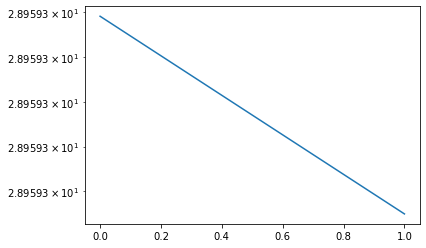



Step :  1e-09  / Number of iterations :  2  / Minimum found :  [6.77955546 5.12958801]  / Loss(w) :  28.959343493699734 

Décroissance de la fonction de coût en fonction du nombre d'itérations


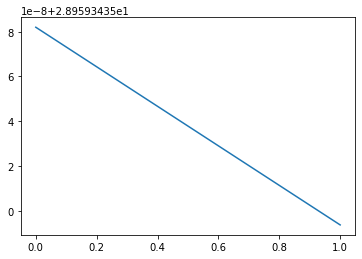


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


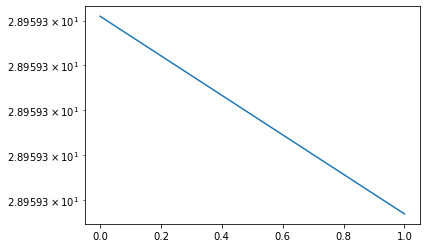

In [14]:
import numdifftools as nd
np.random.seed(120)

# Implementing the log-likelihood written above
def logl(w):
    # First term of the sum
    e = y[0] * ( X[0][0] * w[0] + X[0][1] * w[1] ) - np.log( 1 + np.exp( X[0][0] * w[0] + X[0][1] * w[1] ) )
    # Calculation of the sum
    for i in range(1,100):
        e = e + y[i] * ( X[i][0] * w[0] + X[i][1] * w[1] ) - np.log( 1 + np.exp( X[i][0] * w[0] + X[i][1] * w[1] ) )
    return(-e)

## Gradient Descent

w0 = 10*np.random.rand(2) # w is a random starting point in [-10;10]*[-10;10]
for j in range(1,10):
    w_values = [] # Allows us to store all the l(w) values found through the descent, as weel as the number of iterations
    w_values.append(logl(w0))
    w = w0 # sets the starting point of the descent
    s = 10**(-j) # the step of the descent
    d = [1,1] # initializing the direction of the descent
    diff = d.copy()

    while( np.linalg.norm(diff) > 0.001 ): # while the slope is steep enough
        d = - np.linalg.inv( nd.Hessian(logl)(w) ) @ nd.Gradient(logl)(w) # we calculate for the steepest direction
        w = w + s * d # updates w
        diff = s*d
        w_values.append(logl(w))
    
    # Output : minimum found and plots
    print("Step : ", s, " / Number of iterations : ", len(w_values), " / Minimum found : ", w, " / Loss(w) : ", logl(w), "\n")
    print("Décroissance de la fonction de coût en fonction du nombre d'itérations")
    plt.plot(w_values)
    plt.pause(0.0001)
    print("\nDécroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée")
    plt.semilogy(w_values)
    plt.pause(0.0001)
    print("\n")

In [15]:
pip install numdifftools

Ici nous avons choisi un pas fixe. Afin de vérifier si la méthode de Newton converge bien, nous avons itéré l'algorithme pour plusieurs valeurs de pas différentes. Nous avons affiché les valeurs de minimum trouvées. Nous sélectionnons la valeur qui donne la plus petite log-vraissemblance.


In [16]:
w = [2.06423853, 3.04427315]

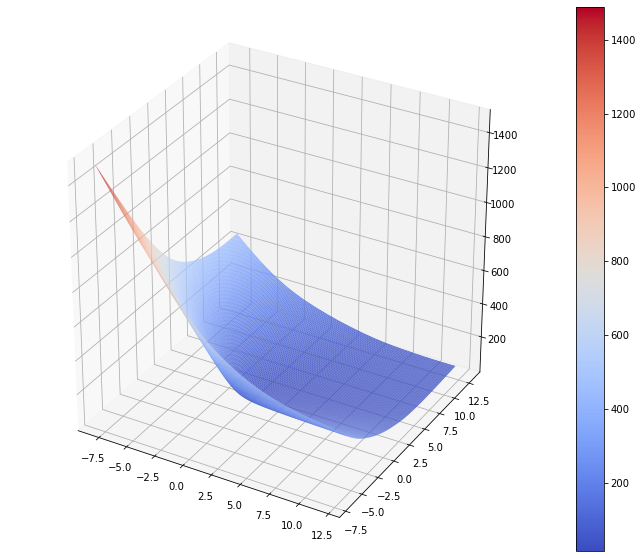

In [17]:
## Let us keep our useless but cool 3D plot :

# Based on Maxime Sangnier's website :
# https://nbviewer.jupyter.org/url/www.lpsm.paris/pageperso/sangnier/files/pythonM2/2-Plotting_student.ipynb?flush_cache=true

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Generating the grid centered in w
x_val = np.arange(w[0] - 10, w[0] +  10, 0.1)
y_val = np.arange(w[1] - 10, w[1] +  10, 0.1)
X_val, Y_val = np.meshgrid(x_val, y_val)
Z_val = X_val.copy()

# Calculating the logl for each point of the above grid
for k in range( len(x_val) ):
    for l in range( len(y_val) ):
        Z_val[k][l] = logl([x_val[k],y_val[l]])

# Initialize 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Plot
surf = ax.plot_surface(X_val, Y_val, Z_val, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

# Colorbar
fig.colorbar(surf);


#### Prediction

Now that the logistic regression has been performed, predict the label for 3 new points that are generated according to the first Gaussian model.

In [18]:
# Prediction for the first class

from random import randrange
np.random.seed(0)

# We choose three random points in our sample (X)
a1 = randrange(100)
a2 = randrange(100)
a3 = randrange(100)

print("Label de chaque point ", y[a1], y[a2], y[a3])

# Calculation of the prediction using our logistic regression model
pred1 = w[0] * X[a1][0] + w[1] * X[a1][1]
pred2 = w[0] * X[a2][0] + w[1] * X[a2][1]
pred3 = w[0] * X[a3][0] + w[1] * X[a3][1]

def pred_reg_log(p):
    if p>0:
        return(1)
    else:
        return(0)

print("Prédictions : ",pred_reg_log(pred1), pred_reg_log(pred2), pred_reg_log(pred3) )

Label de chaque point  1.0 1.0 0.0
Prédictions :  1 1 0


### Another smart way to program




In [19]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            if (i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print(self.__loss(h, y))
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold=0.5):
        return self.predict_prob(X).round()

In [20]:
# Model initialisation
logistic_reg = LogisticRegression()

# Calculation of the model based on the training data
logistic_reg.fit(X,y)

# Generation of predictions :
logistic_reg.predict(X)

0.6882640900471613
0.14993947162890117
0.1491927793701118
0.1491507964559812
0.1491478719708367
0.14914765775498595
0.14914764185507123
0.14914764067069333
0.1491476405823836
0.14914764057579732


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

### To conclude

Relaunch all the code when there is or not a separating hyperplane in the data. Conclude.

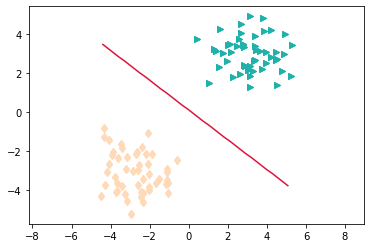

In [21]:
## LDA

np.random.seed(0)
n1=50
n2=50
mu1=[3,3]
mu2=[-3,-3]
sigma=1
X1=Gaussian_sample(mu1,sigma,sigma,0,n1)
X2=Gaussian_sample(mu2,sigma,sigma,0,n2)

plotXY(X1, X2)

X = np.concatenate( (X1,X2), axis = 0 )
y = np.repeat([1,2],50)

lda_maison2 = LDA()
lda_maison2.fit(X,y)
lda_maison2.predict(X)

plotXY(X1, X2)
plot_frontiere(lda_maison2, data=X, num=100, label=y)

# LDA works fine

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  0.1  / Number of iterations :  3  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


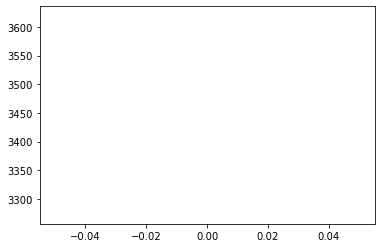


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


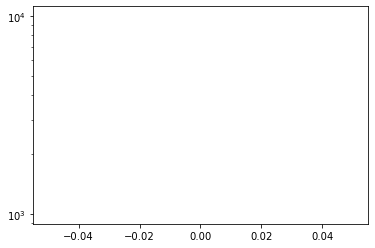

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  0.01  / Number of iterations :  3  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


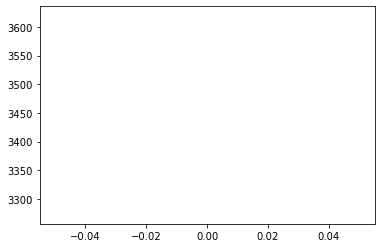


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


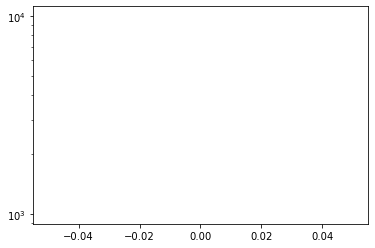

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  0.001  / Number of iterations :  3  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


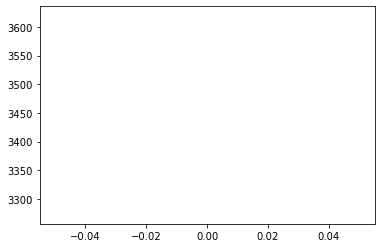


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


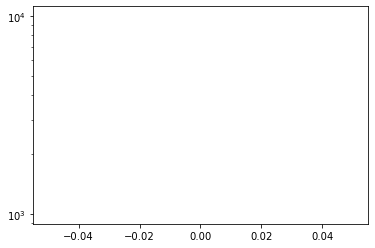

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  0.0001  / Number of iterations :  3  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


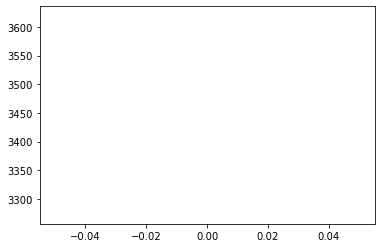


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


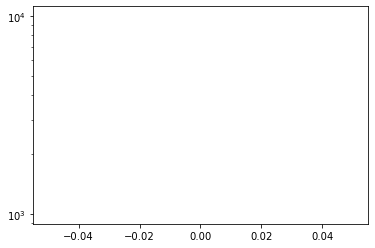

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  1e-05  / Number of iterations :  3  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


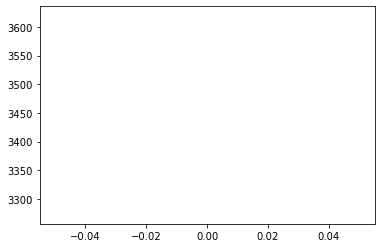


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


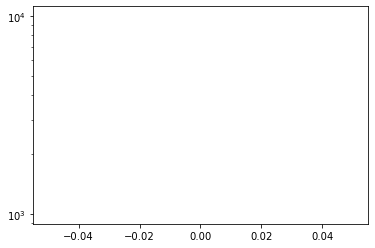

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  1e-06  / Number of iterations :  3  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\limits.py:149: UserWarning: All-NaN slice encountered
  wa

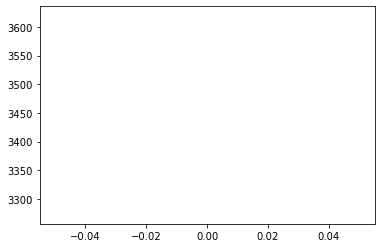


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


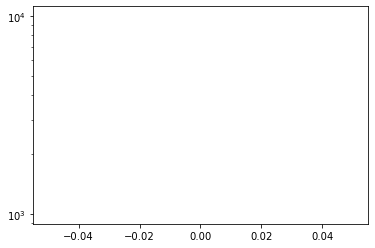

C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:894: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\jafun\Anaconda3\envs\ML\lib\site-packages\numpy\lib\nanfunctions.py:1392: R

Step :  1e-07  / Number of iterations :  4  / Minimum found :  [nan nan]  / Loss(w) :  nan 

Décroissance de la fonction de coût en fonction du nombre d'itérations


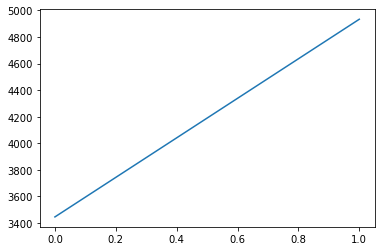


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


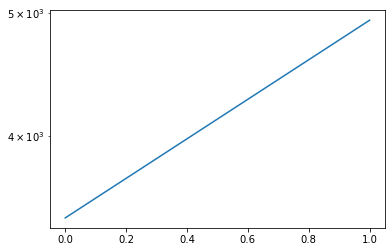



Step :  1e-08  / Number of iterations :  3  / Minimum found :  [-9.35838467 12.87175407]  / Loss(w) :  1677.038298560474 

Décroissance de la fonction de coût en fonction du nombre d'itérations


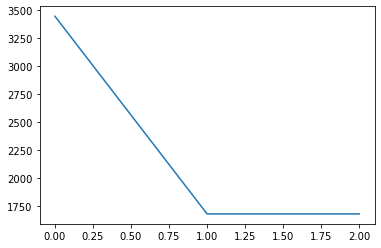


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


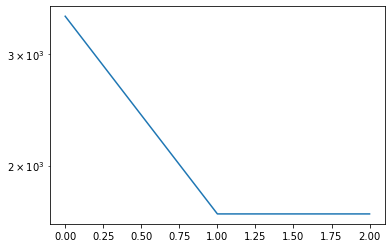



Step :  1e-09  / Number of iterations :  538  / Minimum found :  [2.83123465 4.41135519]  / Loss(w) :  2140.954997837786 

Décroissance de la fonction de coût en fonction du nombre d'itérations


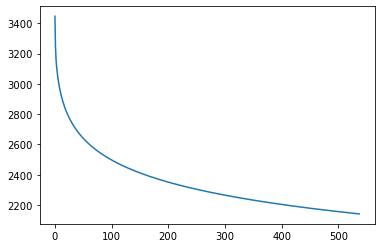


Décroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée


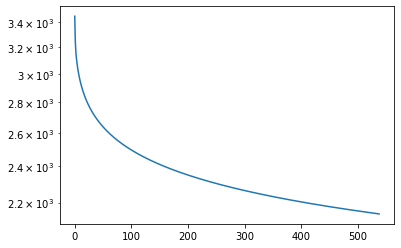

In [22]:
import numdifftools as nd
np.random.seed(120)

# Implementing the log-likelihood written above
def logl(w):
    # First term of the sum
    e = y[0] * ( X[0][0] * w[0] + X[0][1] * w[1] ) - np.log( 1 + np.exp( X[0][0] * w[0] + X[0][1] * w[1] ) )
    # Calculation of the sum
    for i in range(1,100):
        e = e + y[i] * ( X[i][0] * w[0] + X[i][1] * w[1] ) - np.log( 1 + np.exp( X[i][0] * w[0] + X[i][1] * w[1] ) )
    return(-e)

## Gradient Descent

w0 = 10*np.random.rand(2) # w is a random starting point in [-10;10]*[-10;10]
for j in range(1,10):
    w_values = [] # Allows us to store all the l(w) values found through the descent, as weel as the number of iterations
    w_values.append(logl(w0))
    w = w0 # sets the starting point of the descent
    s = 10**(-j) # the step of the descent
    d = [1,1] # initializing the direction of the descent
    diff = d.copy()

    while( np.linalg.norm(diff) > 0.001 ): # while the slope is steep enough
        d = - np.linalg.inv( nd.Hessian(logl)(w) ) @ nd.Gradient(logl)(w) # we calculate for the steepest direction
        w = w + s * d # updates w
        diff = s*d
        w_values.append(logl(w))
    
    # Output : minimum found and plots
    print("Step : ", s, " / Number of iterations : ", len(w_values), " / Minimum found : ", w, " / Loss(w) : ", logl(w), "\n")
    print("Décroissance de la fonction de coût en fonction du nombre d'itérations")
    plt.plot(w_values)
    plt.pause(0.0001)
    print("\nDécroissance de la fonction de coût en fonction du nombre d'itérations / Échelle logarithmique en ordonnée")
    plt.semilogy(w_values)
    plt.pause(0.0001)
    print("\n")

In this example, a separating hyperplane exists for the sample. Thus the log-likelihood does not admit a minimum unlike the previous example. The logistic regression cannot be done. Indeed, we can observe the the exact same algorithm as above fails here.